# Save Results of all Models for a given Data and Model Version

Loop over all Folds and Models and save the results in a dataframe.  
Calculate a threshold for outcome prediction on the validation data (based on geometric mean) and apply it to the test data.  
Add a normalized prediction uncertainty based on the standard deviation of the predictions of the different models.  
Check the calibrartion plots.

## Load Libraries and Modules

In [1]:
#!pip install statsmodels
#!pip install seaborn

In [39]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import pickle as pkl
import time

import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [40]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    print(os.getcwd())

import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat
import Utils_maurice as utils

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

/tf/notebooks/schnemau/xAI_stroke_3d
/tf/notebooks/schnemau/xAI_stroke_3d


## Let's look at some training

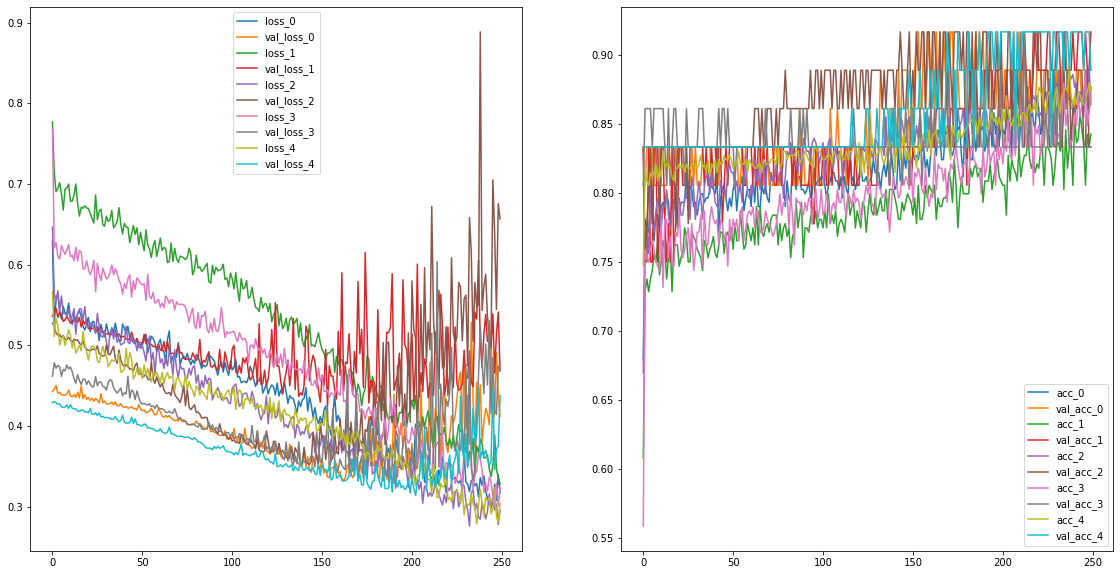

In [41]:
# Create subplots outside the loop
plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
last_activation = "linear" 
which_split = 0
model_version = 1

for i in range(5):
    model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/hist_3d_cnn_binary_model_splitCIB_LSX" + str(which_split) + 
                          "_normalized_avg_layer_paper_model_linear_activation_" + str(model_version) + "_" + str(i) + ".pkl")
    histplt = pkl.load(open(model_name, "rb")) 
    # Plot training history lines
    ax1.plot(histplt['loss'], label=f"loss_{i}")
    ax1.plot(histplt['val_loss'], label=f"val_loss_{i}")
    ax2.plot(histplt['acc'], label=f"acc_{i}")
    ax2.plot(histplt['val_acc'], label=f"val_acc_{i}")

# Add legends and display the plot
ax1.legend()
ax2.legend()
plt.show()

## Load Data and Results

In [42]:
version = "10Fold_CIBLSX" 
layer_connection = "globalAveragePooling" 
last_activation = "linear" 
# Define Model Version
model_version = 1

# should csv be saved?
save_file = True

DATA_OUTPUT_DIR = DIR + "data/"

In [43]:
# Setup the paths for the result assembly
DATA_DIR = DIR + "data/" 
WEIGHT_DIR = DIR + "weights/" + version + "/"
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
all_result_name = "all_tab_results_" + version + "_M" + str(model_version)
which_splits = list(range(0,10)) # 10 Fold
print(id_tab.shape)
print(X.shape)

(407, 14)
(407, 128, 128, 28)


In [44]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/
all_tab_results_10Fold_CIBLSX_M1


In [45]:
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, 1)

input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(X_tab_train.shape[1])
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])



In [46]:
model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(1) + 
                    "_normalized_avg_layer_paper_model_" + last_activation + 
                    "_activation_" + str(1) + "_" + str(1) + ".h5")        

model_3d.load_weights(model_name)        
test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
test_labels = tf.data.Dataset.from_tensor_slices((to_categorical(y_test)))
test_loader = tf.data.Dataset.zip((test_data, test_labels))
test_dataset_pred = (test_loader.batch(len(X_test)))
predic =  predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]


In [47]:
model_nrs = list(range(5))

In [48]:
results_list = [] # test dataset results
valid_list = [] # validation datset results
check_print = True

# loop over splits and models
start = time.time()
for which_split in which_splits:
    if check_print:
        print(" ")
        print("---- Start Reading Data of Split " + str(which_split) + " ----")
        print(" ")
    
    (X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    Y_train = to_categorical(y_train)
    Y_valid = to_categorical(y_valid)
    Y_test = to_categorical(y_test)
        
    test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  
  
  
    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()      
        
    # add variable with current split
    results["test_split"] = which_split        
    
    # create new df for validation set, to calculate classification threshold 
    # => not cheating when calc on valid
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
    #0 = favorable
    #1 = unfavorable

    if check_print:
        print(" ")
        print("---- Starting Result Calculation of Split " + str(which_split) + " ----")
        print(" ")
        
    y_test_preds = []
    y_valid_preds = []
    
     
    for model_nr in model_nrs:
        if check_print:
            print("Now calculating model nr. " + str(model_nr))  
        
        model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
                          "_normalized_avg_layer_paper_model_" + last_activation + 
                          "_activation_" + str(model_version) + "_" + str(model_nr) + ".h5")        
        
        model_3d.load_weights(model_name)        
         
        #test
       
        predic =  predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   


    y_test_preds = np.array(y_test_preds)
    results["y_pred_linear_avg"] = np.mean(y_test_preds, axis = 0)
    results["y_pred_trafo_avg"] = fm.sigmoid(np.mean(fm.inverse_sigmoid(y_test_preds), axis = 0))
    
    y_valid_preds = np.array(y_valid_preds)
    validation_results["y_pred_linear_avg"] = np.mean(y_valid_preds, axis = 0)
    validation_results["y_pred_trafo_avg"] = fm.sigmoid(np.mean(fm.inverse_sigmoid(y_valid_preds), axis = 0))
        
    results_list.append(results)
    valid_list.append(validation_results)
        
if check_print:
    end = time.time()
    print(" ")
    print("---- DONE ----")
    print(" ")   
    print("Duration of Execution: " + str(end-start))               

 
---- Start Reading Data of Split 0 ----
 
 
---- Starting Result Calculation of Split 0 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 1 ----
 
 
---- Starting Result Calculation of Split 1 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 2 ----
 
 
---- Starting Result Calculation of Split 2 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 3 ----
 
 
---- Starting Result Calculation of Split 3 ----
 
Now calculating model nr. 0
Now calculating model nr. 1
Now calculating model nr. 2
Now calculating model nr. 3
Now calculating model nr. 4
 
---- Start Reading Data of Split 4 ----
 
 
---- S

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [12]:
# should threshold be calculated per split or over all?

 
---- Split 0 ----
 
Optimal Geometric Mean Threshold: 0.19537042
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8536585365853658
Spezifität:  0.9090909090909091
Sensitivität:  0.625


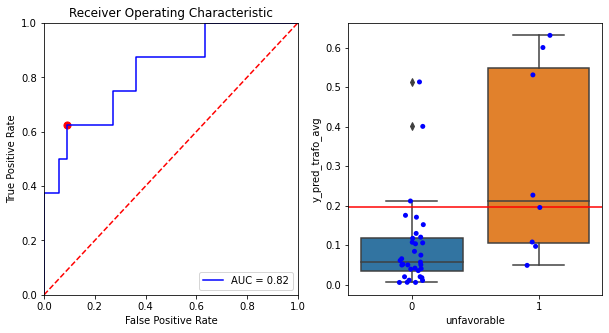

 
---- Split 1 ----
 
Optimal Geometric Mean Threshold: 0.32031688
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8536585365853658
Spezifität:  0.9090909090909091
Sensitivität:  0.625


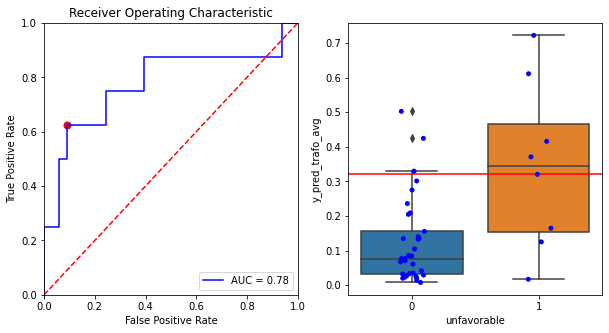

 
---- Split 2 ----
 
Optimal Geometric Mean Threshold: 0.24700506
Accuracy to beat: 0.825
Accuracy: 0.9
Spezifität:  0.9393939393939394
Sensitivität:  0.7142857142857143


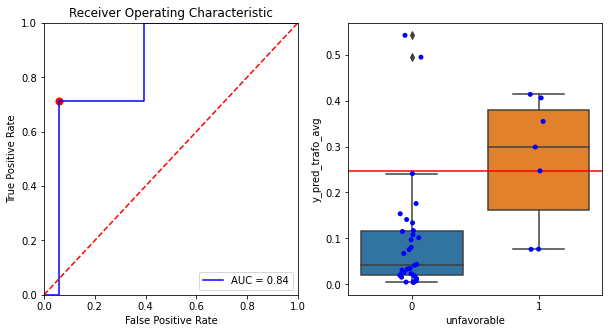

 
---- Split 3 ----
 
Optimal Geometric Mean Threshold: 0.1645376
Accuracy to beat: 0.825
Accuracy: 0.8
Spezifität:  0.7878787878787878
Sensitivität:  0.8571428571428571


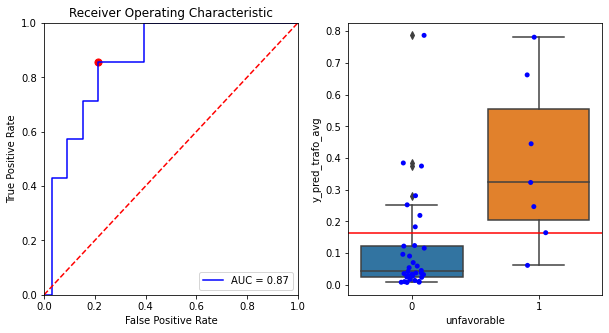

 
---- Split 4 ----
 
Optimal Geometric Mean Threshold: 0.22855856
Accuracy to beat: 0.825
Accuracy: 0.875
Spezifität:  0.9393939393939394
Sensitivität:  0.5714285714285714


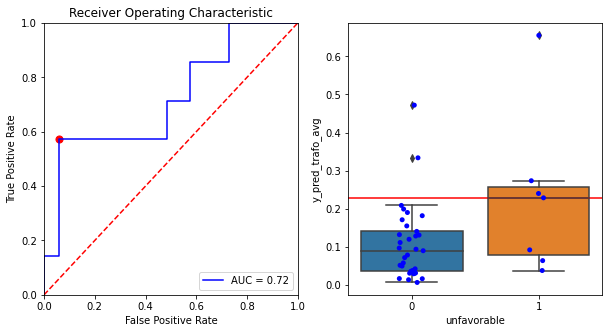

 
---- Split 5 ----
 
Optimal Geometric Mean Threshold: 0.4284479
Accuracy to beat: 0.8292682926829268
Accuracy: 0.975609756097561
Spezifität:  1.0
Sensitivität:  0.8571428571428571


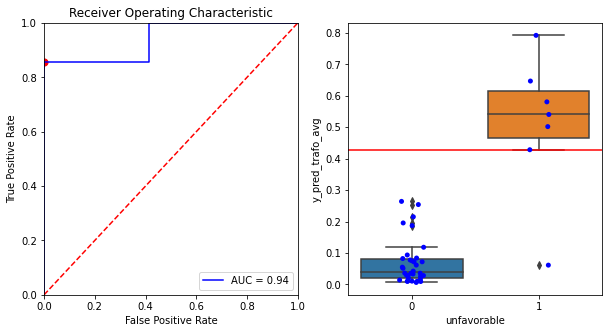

 
---- Split 6 ----
 
Optimal Geometric Mean Threshold: 0.09997601
Accuracy to beat: 0.8292682926829268
Accuracy: 0.6829268292682927
Spezifität:  0.6176470588235294
Sensitivität:  1.0


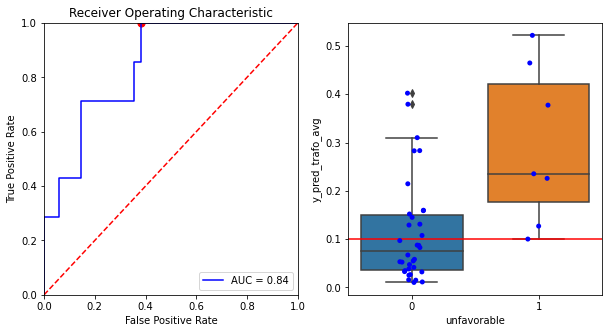

 
---- Split 7 ----
 
Optimal Geometric Mean Threshold: 0.08660449
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.7575757575757576
Sensitivität:  1.0


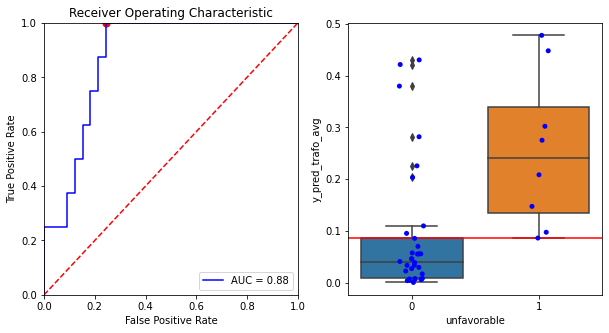

 
---- Split 8 ----
 
Optimal Geometric Mean Threshold: 0.1454266
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.7878787878787878
Sensitivität:  0.875


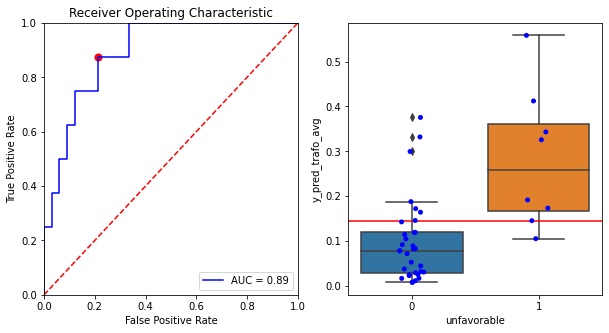

 
---- Split 9 ----
 
Optimal Geometric Mean Threshold: 0.21972848
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8048780487804879
Spezifität:  0.8181818181818181
Sensitivität:  0.75


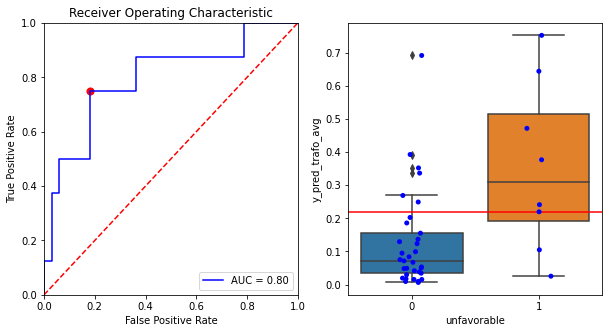

In [49]:
valid_thresholds = []

for i, validation_results in enumerate(valid_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")
    
    y_org = validation_results["unfavorable"]
    y_pred = validation_results["y_pred_trafo_avg"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    valid_thresholds.append(threshold[index])
    print("Optimal Geometric Mean Threshold: " + str(threshold[index]))
    
    # Calc Acc
    y_pred_label = (y_pred >= threshold[index]).squeeze()
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred_label == y_org)))
          
    print("Spezifität: ", 1-fpr[index])
    print("Sensitivität: ", tpr[index])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = validation_results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = validation_results,
        ax = ax2)
    ax2.axhline(y = threshold[index], color = "red")
    
    plt.show()

In [50]:
valid_thresholds

[0.19537042,
 0.32031688,
 0.24700506,
 0.1645376,
 0.22855856,
 0.4284479,
 0.09997601,
 0.08660449,
 0.1454266,
 0.21972848]

### Apply Threshold to Testdata

 
---- Split 0 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.926829268292683
Spezifität:  0.9411764705882353
Sensitivität:  0.8571428571428571


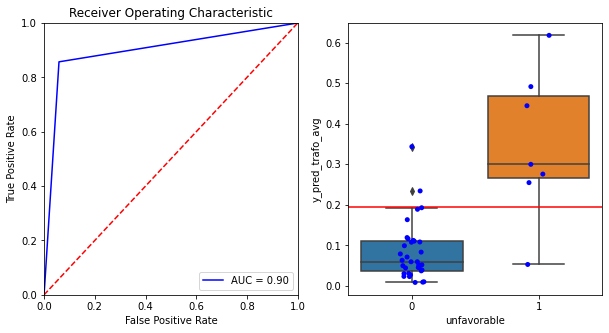

 
---- Split 1 ----
 
Accuracy to beat: 0.8292682926829268
Accuracy: 0.7804878048780488
Spezifität:  0.8235294117647058
Sensitivität:  0.5714285714285714


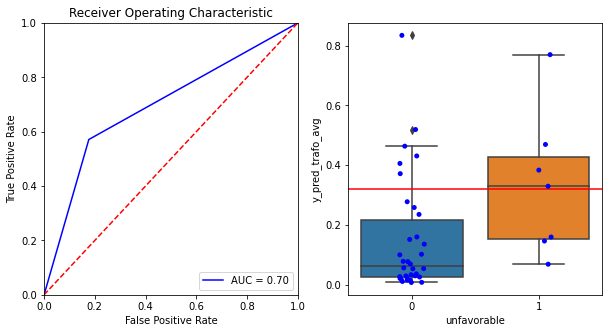

 
---- Split 2 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.7804878048780488
Spezifität:  0.9090909090909091
Sensitivität:  0.25


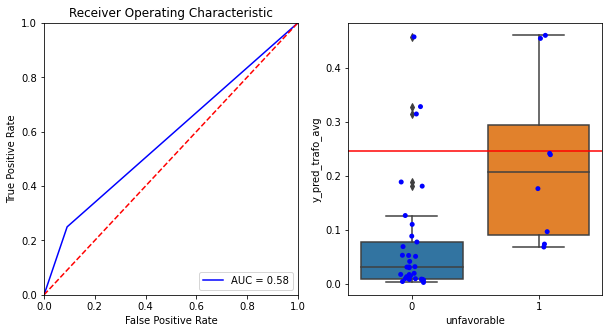

 
---- Split 3 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6829268292682927
Spezifität:  0.696969696969697
Sensitivität:  0.625


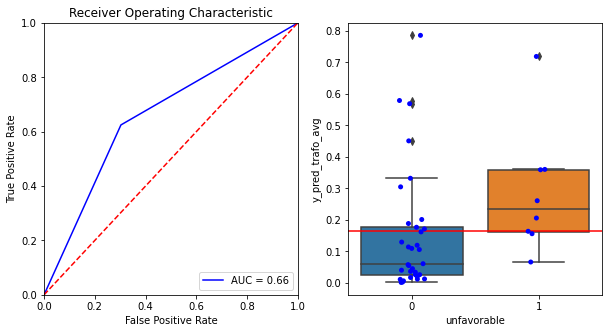

 
---- Split 4 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8292682926829268
Spezifität:  0.8787878787878788
Sensitivität:  0.625


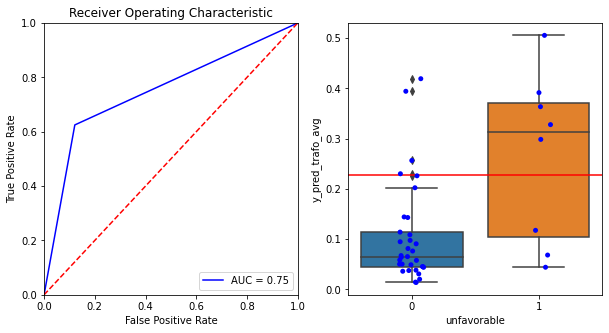

 
---- Split 5 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.8780487804878049
Spezifität:  1.0
Sensitivität:  0.375


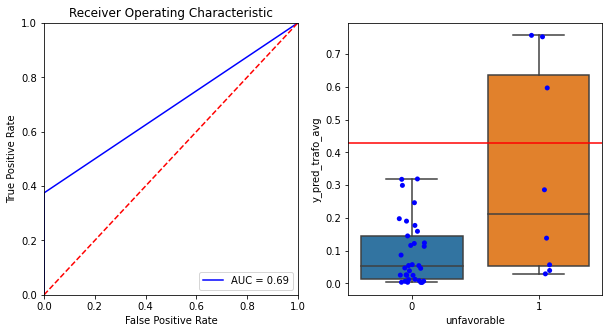

 
---- Split 6 ----
 
Accuracy to beat: 0.8048780487804879
Accuracy: 0.6829268292682927
Spezifität:  0.6363636363636364
Sensitivität:  0.875


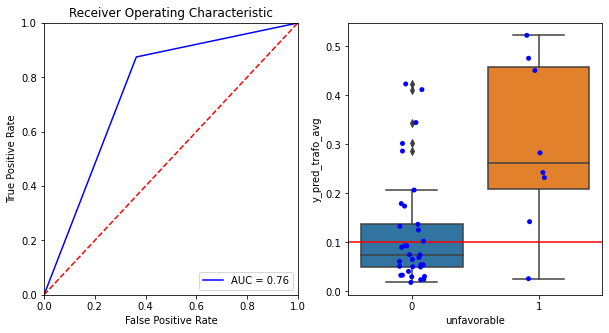

 
---- Split 7 ----
 
Accuracy to beat: 0.825
Accuracy: 0.675
Spezifität:  0.6363636363636364
Sensitivität:  0.8571428571428571


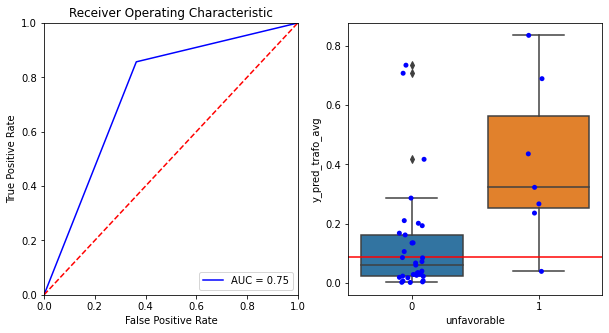

 
---- Split 8 ----
 
Accuracy to beat: 0.825
Accuracy: 0.85
Spezifität:  0.8787878787878788
Sensitivität:  0.7142857142857143


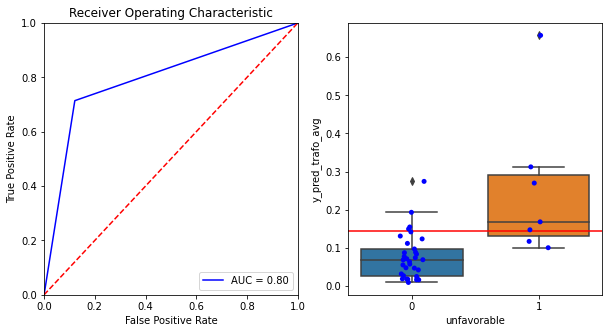

 
---- Split 9 ----
 
Accuracy to beat: 0.825
Accuracy: 0.75
Spezifität:  0.8181818181818181
Sensitivität:  0.42857142857142855


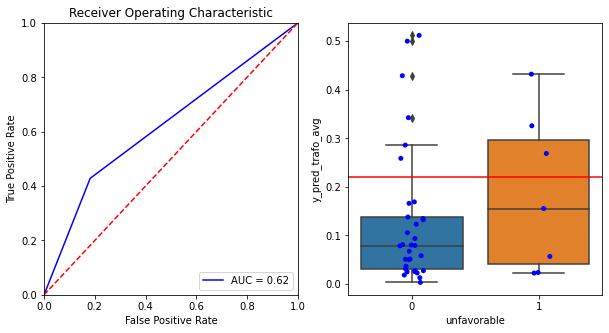

In [51]:
for i, results in enumerate(results_list):
    print(" ")
    print("---- Split " + str(which_splits[i]) + " ----")
    print(" ")

    results["threshold"] = valid_thresholds[i]
    results["y_pred_class"] = (results["y_pred_trafo_avg"] >= results["threshold"]).astype(int)
    
    y_org = results["unfavorable"]
    y_pred = results["y_pred_class"]
    
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
      
    # Calc Acc
    print("Accuracy to beat: " + str(1 - np.mean(y_org)))
    print("Accuracy: " + str(np.mean(y_pred == y_org)))
          
    print("Spezifität: ", 1-fpr[1])
    print("Sensitivität: ", tpr[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    
    # method I: plt
    ax1.title.set_text('Receiver Operating Characteristic')
    ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax1.legend(loc = 'lower right')
    ax1.plot([0, 1], [0, 1],'r--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    sns.boxplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        data = results,
        ax = ax2)
    sns.stripplot(x = "unfavorable",
        y = "y_pred_trafo_avg",
        color = 'blue',
        data = results,
        ax = ax2)
    ax2.axhline(y = valid_thresholds[i], color = "red")
    
    plt.show()

#### Concat all Pandas and Analyze

In [52]:
all_results = pd.concat(results_list)
all_results.shape

(407, 24)

In [53]:
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class
13,14,21,1.0,0,test,train,train,train,train,val,...,0,0.021409,0.008706,0.011752,0.004347,0.010668,0.011376,0.010045,0.195370,0
26,27,36,0.0,0,test,train,train,train,train,val,...,0,0.078482,0.066415,0.218940,0.026023,0.091565,0.096285,0.078780,0.195370,0
27,28,38,2.0,0,test,train,train,train,train,val,...,0,0.031955,0.046325,0.092207,0.052394,0.227226,0.090021,0.071203,0.195370,0
33,34,44,1.0,0,test,train,train,train,train,val,...,0,0.170456,0.250173,0.151111,0.181767,0.202023,0.191106,0.188954,0.195370,0
34,35,46,0.0,0,test,train,train,train,train,val,...,0,0.008533,0.018001,0.007016,0.006057,0.006401,0.009202,0.008405,0.195370,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,345,486,0.0,0,train,train,train,train,val,train,...,9,0.138624,0.073613,0.284167,0.183057,0.216218,0.179136,0.166124,0.219728,0
369,370,514,3.0,1,train,train,train,train,val,train,...,9,0.237644,0.065619,0.014339,0.122743,0.017489,0.091567,0.056816,0.219728,0
393,394,541,0.0,0,train,train,train,train,val,train,...,9,0.048625,0.023103,0.035995,0.025119,0.011267,0.028822,0.025886,0.219728,0
396,397,546,1.0,0,train,train,train,train,val,train,...,9,0.107886,0.034730,0.009225,0.018005,0.023540,0.038677,0.027449,0.219728,0


Accuracy to beat: 0.8157248157248157
Accuracy: 0.7837837837837838
Spezifität:  0.822289156626506
Sensitivität:  0.6133333333333333


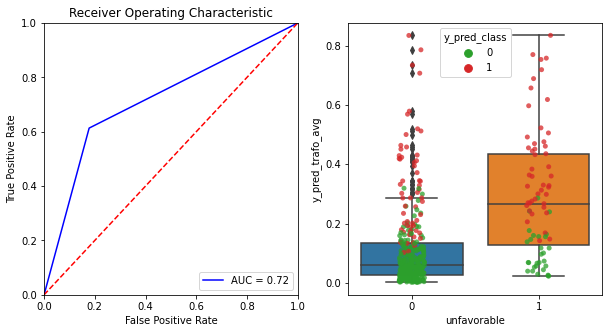

In [54]:
y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class"]

# calculate fpr, tpr and thresholds
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# Calc Acc
y_pred_label = all_results["y_pred_class"]
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[1])
print("Sensitivität: ", tpr[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class',
    palette=["C2", "C3", "k"],
    data = all_results,
    alpha = 0.75,
    ax = ax2)
    

## Calculation of one threshold

1. Threshold based on all validation data. This makes not much sense as each fold has different models.
2. Threshold based on the validation data of each fold. This approach is used in the end.

threshold:  0.1645376
Accuracy to beat: 0.8157248157248157
Accuracy: 0.7985257985257985
Spezifität:  0.8162650602409638
Sensitivität:  0.72


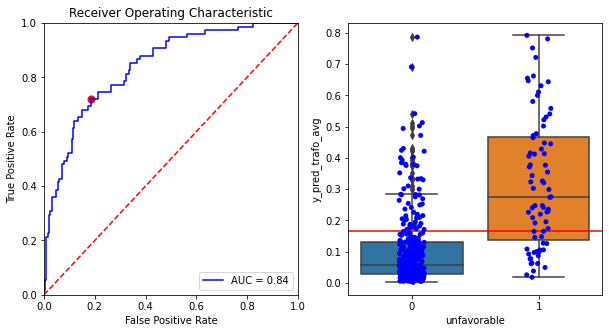

In [55]:
# 1.
all_valid_results = pd.concat(valid_list)

y_org = all_valid_results["unfavorable"]
y_pred = all_valid_results["y_pred_trafo_avg"]

fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate geometric mean of tpr and fpr to find best threshold
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
valid_threshold = threshold[index]
print("threshold: ", threshold[index])


y_pred_label = (y_pred >= threshold[index]).squeeze()
print("Accuracy to beat: " + str(1 - np.mean(y_org)))
print("Accuracy: " + str(np.mean(y_pred_label == y_org)))

print("Spezifität: ", 1-fpr[index])
print("Sensitivität: ", tpr[index])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.scatter(fpr[index], tpr[index], color = "red", s = 50)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_valid_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    color = 'blue',
    data = all_valid_results,
    ax = ax2)
ax2.axhline(y = threshold[index], color = "red")

Accuracy to beat:     0.8157
Accuracy:             0.769
-----------------[95% Conf.]-----------------
AUC of probabilities: 0.7956 [0.7388 0.8466]
NLL :                 0.3989
Threshold:            0.1645
Spezifität:           0.7982 [0.7517 0.8378]
Sensitivität:         0.64 [0.527  0.7394]


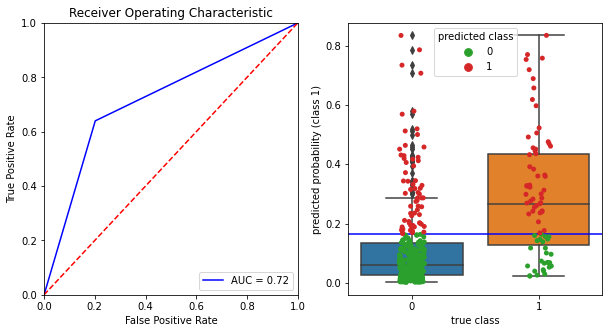

In [56]:
# 2.
all_results["threshold2"] = valid_threshold
all_results["y_pred_class2"] = (all_results["y_pred_trafo_avg"] >= all_results["threshold2"]).astype(int)

y_org = all_results["unfavorable"]
y_pred = all_results["y_pred_class2"]
y_pred_prob = all_results["y_pred_trafo_avg"]

# calculate fpr and tpr for probabilities
fpr_prob, tpr_prob, thresholds_prob = metrics.roc_curve(y_org, y_pred_prob)

# calculate fpr, tpr and thresholds for class
fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# calculate AUC confint
AUC0_CI = fm.compute_auc_ci(y_org, y_pred_prob)

# calculate spez and sens confint
cm = confusion_matrix(y_org, y_pred)
# sens
nobs = sum([cm[1,0],cm[1,1]])
count = sum([cm[1,1]])
sens_ci_low, sens_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#spec 
nobs = sum([cm[0,1],cm[0,0]])
count = sum([cm[0,0]])
spec_ci_low, spec_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')

# Calc Acc
print("Accuracy to beat:     " + str(round(1 - np.mean(y_org), 4)))
print("Accuracy:             " + str(round(np.mean(y_pred == y_org), 4)))
print("-----------------[95% Conf.]-----------------")

print("AUC of probabilities: " + str(round(metrics.auc(fpr_prob, tpr_prob), 4)) + " " +
                                 str(np.around([AUC0_CI[0], AUC0_CI[1]],4)))
print("NLL :                 " + str(round(metrics.log_loss(y_org, y_pred_prob), 4)))

print("Threshold:            " + str(round(valid_threshold, 4)))

print("Spezifität:           " + str(round(1-fpr[1], 4)) + " " +
                                 str(np.around([spec_ci_low, spec_ci_upp],4)))
print("Sensitivität:         " + str(round(tpr[1], 4)) + " " +
                                 str(np.around([sens_ci_low, sens_ci_upp],4)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# method I: plt
ax1.title.set_text('Receiver Operating Characteristic')
ax1.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax1.legend(loc = 'lower right')
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')

sns.boxplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    data = all_results,
    ax = ax2)
sns.stripplot(x = "unfavorable",
    y = "y_pred_trafo_avg",
    hue = 'y_pred_class2',
    palette=["C2", "C3"],
    data = all_results,
    ax = ax2)
plt.legend(title='predicted class', loc='upper center')
ax2.set(xlabel='true class', ylabel='predicted probability (class 1)')
ax2.axhline(y = valid_threshold, color = "blue")

In [57]:
# Check 10 choosen patients which are also in andreas split 6 
all_results[all_results.p_id.isin([27,35,125,297,299,319,460,481,483,529])
            ][["p_id", "mrs", "unfavorable", "test_split", 
               "y_pred_model_" + "0", "y_pred_model_" + "1", 
               "y_pred_model_" + "2", "y_pred_model_" + "3", 
               "y_pred_model_" + "4", 
               "y_pred_trafo_avg", "y_pred_class"]].sort_values(by = "p_id")


,p_id,mrs,unfavorable,test_split,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_trafo_avg,y_pred_class
19,27,2.0,0,2,0.282237,0.332712,0.531247,0.245229,0.221258,0.314891,1
25,35,0.0,0,3,0.266402,0.045528,0.329129,0.083156,0.055943,0.119329,0
85,125,0.0,0,2,0.000218,0.004386,0.000833,0.043520,0.023484,0.003863,0
213,297,4.0,1,2,0.707930,0.258921,0.247535,0.701721,0.383298,0.455215,1
215,299,4.0,1,8,0.566375,0.112419,0.299707,0.059037,0.071175,0.168390,1
234,319,3.0,1,9,0.482126,0.126781,0.194474,0.385517,0.247338,0.268882,1
323,460,4.0,1,6,0.705746,0.800903,0.022793,0.893102,0.166013,0.451017,1
340,481,0.0,0,8,0.047023,0.006664,0.040894,0.004671,0.019860,0.016532,0
342,483,6.0,1,9,0.232804,0.503757,0.100110,0.456350,0.478451,0.325862,1
384,529,5.0,1,1,0.500947,0.094198,0.438966,0.436814,0.895294,0.469384,1


## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [58]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

[Text(0, 0.5, 'prediction uncertainty'), Text(0.5, 0, 'true class')]

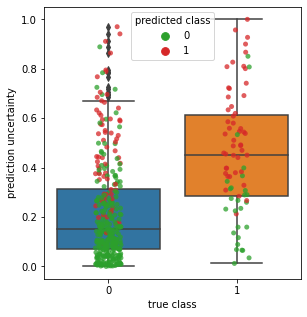

In [59]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class2',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

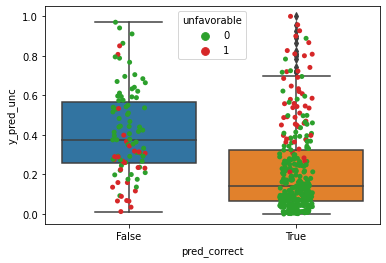

In [60]:
all_results["pred_correct"] = all_results["y_pred_class2"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

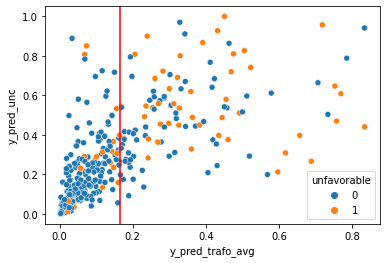

In [61]:
sns.scatterplot(
           x = "y_pred_trafo_avg",
           y = "y_pred_unc",
           hue = "unfavorable",
           data = all_results)
plt.axvline(x = valid_threshold, color = "red")

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [62]:
all_results = all_results.drop(columns = ["y_pred_class", "threshold"])
all_results = all_results.rename(columns = {"y_pred_class2": "y_pred_class", "threshold2": "threshold"})

In [64]:
save_file = True

In [65]:
if save_file:
    all_results.to_csv(DATA_OUTPUT_DIR + all_result_name + ".csv",  index=False) # rename output file!!!!

In [66]:
all_result_name

'all_tab_results_10Fold_CIBLSX_M1'

# Check Splits

Only used for andreas/paper split:  
Shows the different predictions (and uncertainties) for patients which were in multiple test splits.

In [30]:
if version == "andrea":    
    andrea_splits = pd.read_csv(split_path, 
                                    sep='\,', header = None, engine = 'python', 
                                    usecols = [1,2,3]).apply(lambda x: x.str.replace(r"\"",""))
    andrea_splits.columns = andrea_splits.iloc[0]
    andrea_splits.drop(index=0, inplace=True)
    andrea_splits = andrea_splits.astype({'idx': 'int32', 'spl': 'int32'})
    print(andrea_splits[andrea_splits["type"].isin(["test"])].idx.nunique())
    print(sum(andrea_splits["type"].isin(["test"])))

In [31]:
if version == "andrea":
    all_p_dup = all_results[all_results["p_id"].duplicated()]["p_id"].unique()
    all_dup = all_results[all_results["p_id"].isin(all_p_dup)].sort_values("p_id")
    all_dup["p_id"].value_counts().value_counts()

In [32]:
if version == "andrea":
    print("Total duplicate: ", len(all_dup["p_id"].value_counts()))

    print("gleich klassifieziert (%): ", np.mean(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))
    print("gleich klassifieziert (abs): ", np.sum(all_dup.groupby("p_id").y_pred_class.mean().isin([0,1])))

In [33]:
if version == "andrea":
    sns.histplot(all_dup.groupby("p_id").y_pred_trafo_avg.std())

In [34]:
if version == "andrea":
    all_dup

## Calibration Plot

Plot the calibration of all models and the mean calibration.

In [35]:
cal_plot_datas = []
for split in which_splits:
    dat = all_results.loc[all_results["test_split"] == split]
    cal_plot_datas.append(fm.cal_plot_data_prep(
        dat["y_pred_trafo_avg"].array, dat["unfavorable"].array
    ).select_dtypes(include=np.number))

In [36]:
all_cal_plot_datas = pd.concat(cal_plot_datas)
all_cal_plot_datas["iter"] = all_cal_plot_datas.index
all_cal_plot_datas = all_cal_plot_datas.groupby("iter")[
    ["predicted_probability_middle", "observed_proportion", "observed_proportion_lower", "observed_proportion_upper"]].mean()

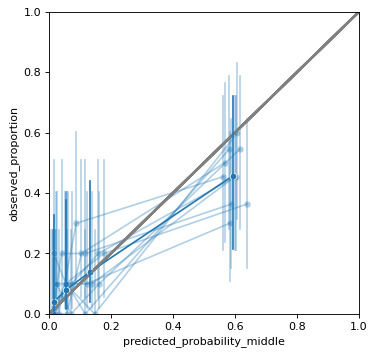

In [37]:
from matplotlib.pyplot import figure
figure(figsize=(5, 5), dpi=80)

for i in range(len(which_splits)):
    fm.cal_plot(cal_plot_datas[i], 
             "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper", alpha = .35, show = False)
fm.cal_plot(all_cal_plot_datas, "predicted_probability_middle", "observed_proportion",
                        "observed_proportion_lower", "observed_proportion_upper")

## Check Volume index

Check if X_test is the same when selected via p_idx as when directly selected.  
This must be true to make sure the correct volume is accessed for the heatmaps.

In [38]:
with h5py.File("/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5", "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

OSError: Unable to open file (unable to open file: name = '/tf/notebooks/hezo/stroke_zurich/data/dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
index = 0
results.p_id.array[0]

In [ ]:
np.argwhere(pat == results.p_id.array[index]).squeeze()

In [ ]:
im1 = X_test[index].astype("float64")
im2 = X_in[np.argwhere(pat == results.p_id.array[index]).squeeze()].astype("float64")
np.allclose(im1, im2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(im1[:,:,14])
ax2.imshow(im2[:,:,14])